In [96]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [97]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [98]:
%cd /Users/irfanmasudi/ANNDL/Challenge2

/Users/irfanmasudi/ANNDL/Challenge2


In [99]:
dataset = pd.read_csv('Training.csv')

In [100]:
dataset.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [101]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [102]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col], linewidth=0.7)
        axs[i].set_title(col)
    plt.show()

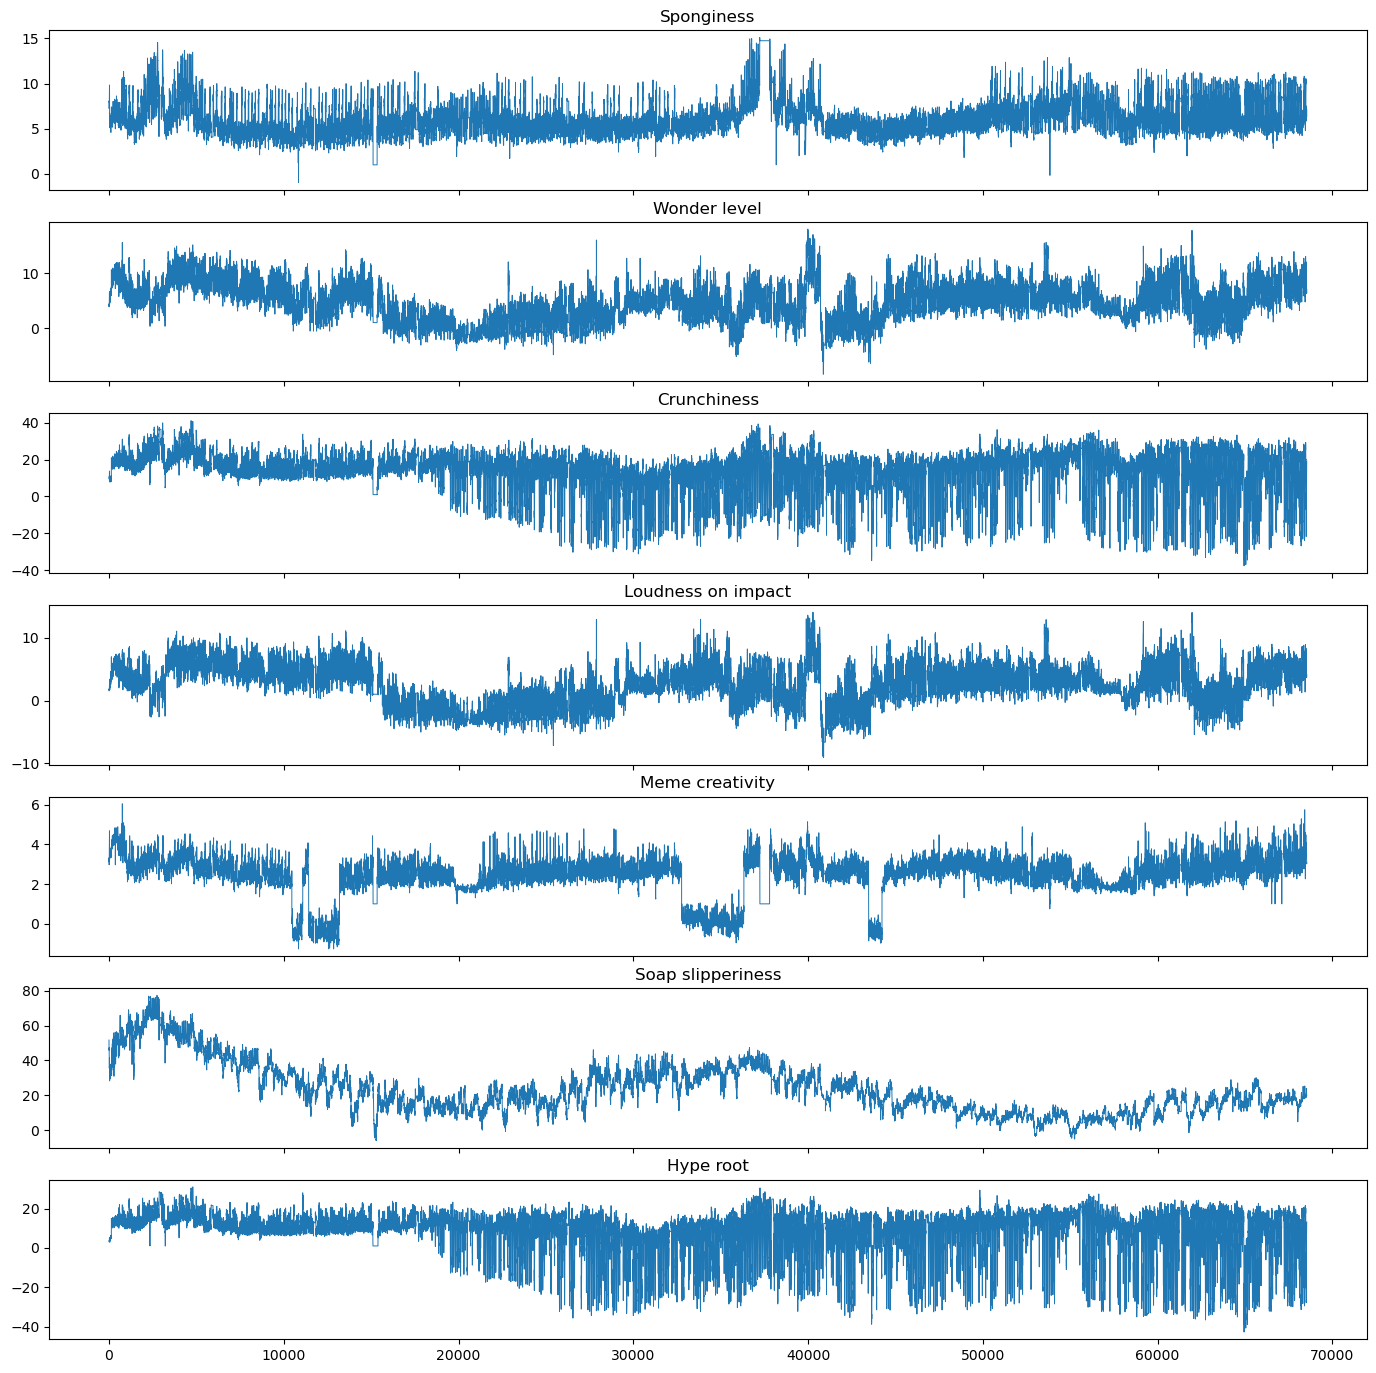

In [103]:
inspect_dataframe(dataset, dataset.columns)

In [104]:
#Splitting in train and test datasets
train_size = int(dataset.shape[0] * 0.95)
X_train = dataset.iloc[:train_size]
X_test  = dataset.iloc[train_size:]
X_train.shape, X_test.shape

((65101, 7), (3427, 7))

In [105]:
X_train.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [106]:
#Data Normalization
X_min = X_train.min()
X_max = X_train.max()

X_train = (X_train - X_min)/(X_max - X_min)
X_test = (X_test - X_min)/(X_max - X_min)

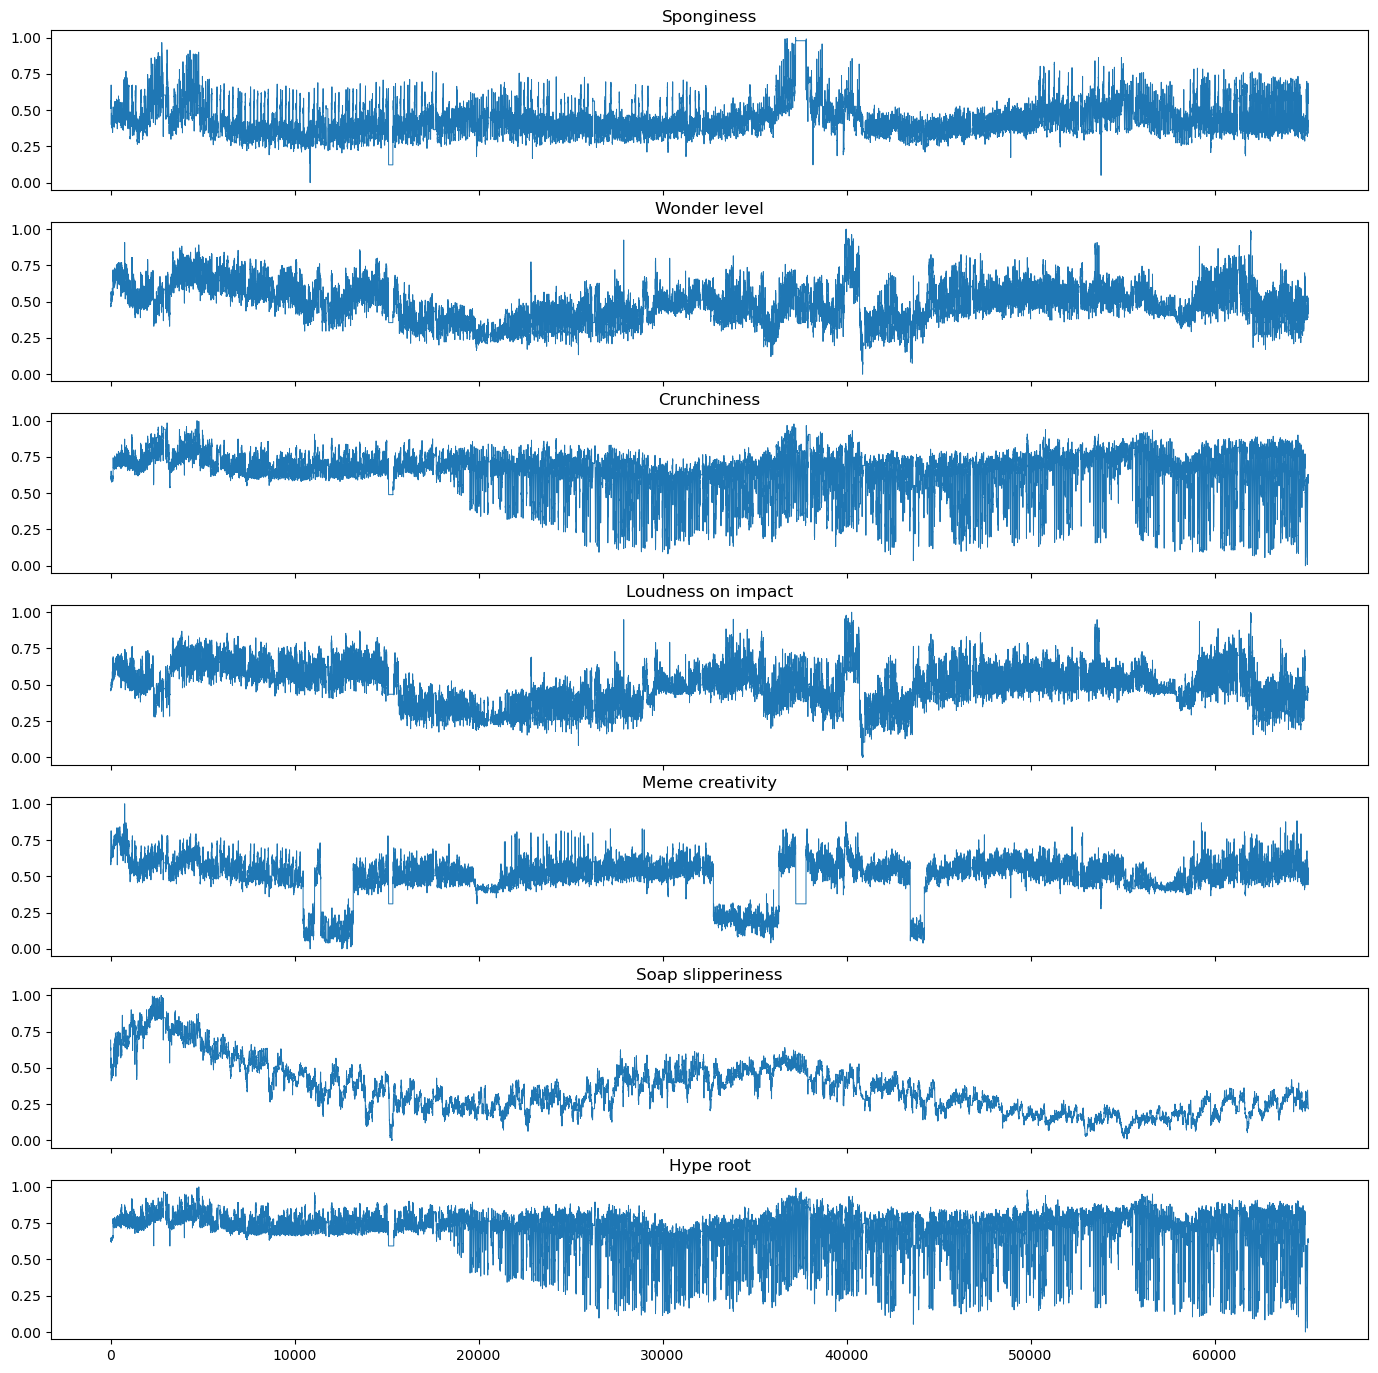

In [107]:
inspect_dataframe(X_train, X_train.columns)

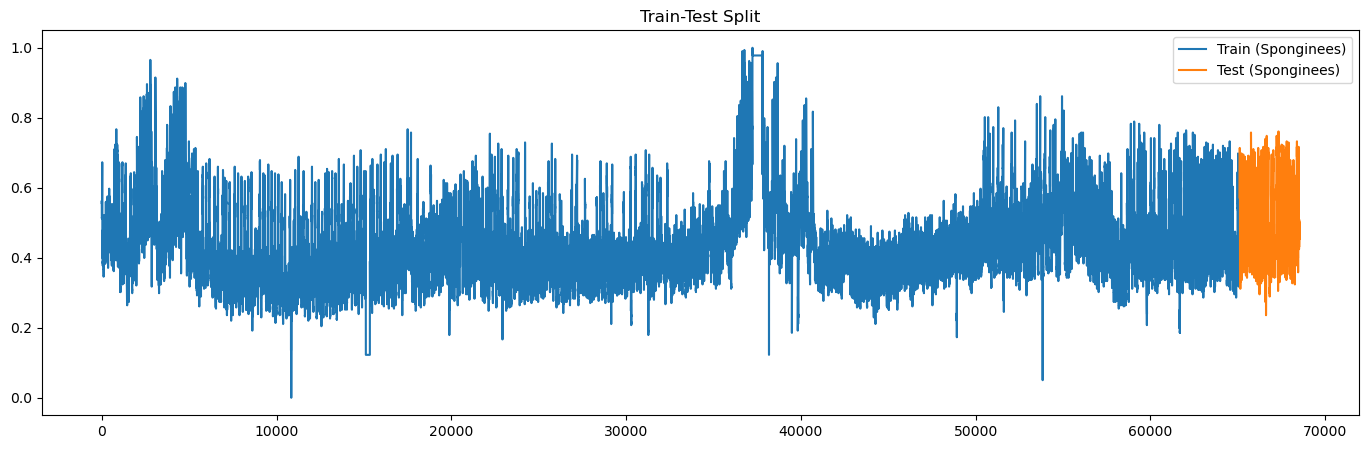

In [108]:
plt.figure(figsize=(17,5))
plt.plot(X_train.Sponginess, label='Train (Sponginees)')
plt.plot(X_test.Sponginess, label='Test (Sponginees)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [109]:
def build_sequences(df, target_labels, window=200, stride=20, telescope=50):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset     = []
    labels      = []
    temp_df     = df.copy().values
    temp_label  = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding     = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df     = np.concatenate((padding,df))
        padding     = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label  = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels  = np.array(labels)
    return dataset, labels

In [110]:
target_labels = dataset.columns
window = 200
stride = 10
telescope = 50
X_train, y_train = build_sequences(X_train, target_labels, window, stride, telescope)
X_test , y_test  = build_sequences(X_test, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3248, 200, 7), (3248, 50, 7), (168, 200, 7), (168, 50, 7))

In [111]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((200, 7), (50, 7))

In [121]:
def build_biLSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(bilstm)
    gap = tfkl.GlobalAveragePooling1D()(bilstm)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)
    
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(dropout)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [88]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 7)]          0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200, 256)          139264    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 200, 512)          1050624   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 350)               179550    
_________________________________________________________________
reshape_10 (Reshape)         (None, 50, 7)             0     

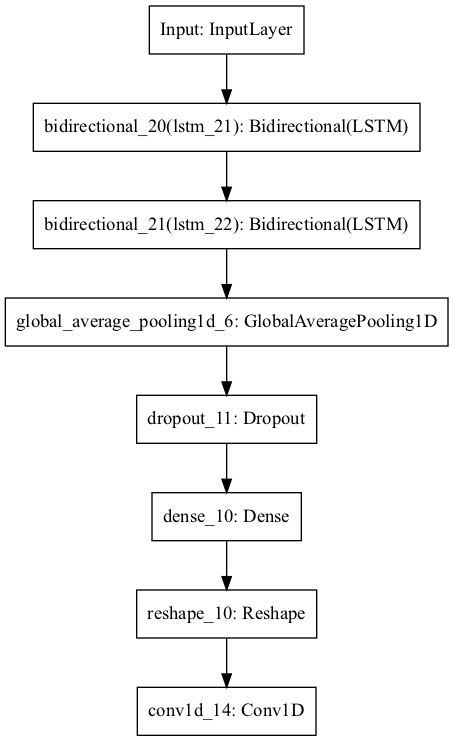

In [122]:
model = build_biLSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [124]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('logs/biLSTM')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tfk.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tfk.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # --------------
    es_callback = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)
    
  # ReduceLR
    rl_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    callbacks.append(rl_callback)
    
    return callbacks

In [125]:
epochs     = 200
batch_size = 24

tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs

callbacks = create_folders_and_callbacks(model_name='BiLstmGap')

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

Epoch 1/200
122/122 [==============================] - 71s 537ms/step - loss: 0.2054 - mae: 0.3832 - val_loss: 0.1350 - val_mae: 0.2993


Epoch 2/200
122/122 [==============================] - 49s 396ms/step - loss: 0.0758 - mae: 0.2081 - val_loss: 0.0467 - val_mae: 0.1646


Epoch 3/200
122/122 [==============================] - 48s 387ms/step - loss: 0.0338 - mae: 0.1375 - val_loss: 0.0331 - val_mae: 0.1354


Epoch 4/200
122/122 [==============================] - 49s 398ms/step - loss: 0.0238 - mae: 0.1151 - val_loss: 0.0273 - val_mae: 0.1231


Epoch 5/200
122/122 [==============================] - 49s 400ms/step - loss: 0.0213 - mae: 0.1093 - val_loss: 0.0243 - val_mae: 0.1145


Epoch 6/200
122/122 [==============================] - 47s 385ms/step - loss: 0.0209 - mae: 0.1087 - val_loss: 0.0238 - val_mae: 0.1142


Epoch 7/200
122/122 [==============================] - 47s 382ms/step - loss: 0.0192 - mae: 0.1044 - val_loss: 0.0221 - val_mae: 0.1087


Epoch 8/200
122/122 [==============================] - 48s 388ms/step - loss: 0.0181 - mae: 0.1019 - val_loss: 0.0228 - val_mae: 0.1104


Epoch 9/200
122/122 [==============================] - 54s 437ms/step - loss: 0.0177 - mae: 0.1008 - val_loss: 0.0224 - val_mae: 0.1104


Epoch 10/200
122/122 [==============================] - 54s 437ms/step - loss: 0.0178 - mae: 0.1011 - val_loss: 0.0221 - val_mae: 0.1091


Epoch 11/200
122/122 [==============================] - 51s 415ms/step - loss: 0.0182 - mae: 0.1020 - val_loss: 0.0221 - val_mae: 0.1091


Epoch 12/200
122/122 [==============================] - 49s 402ms/step - loss: 0.0201 - mae: 0.1075 - val_loss: 0.0222 - val_mae: 0.1113


Epoch 13/200
122/122 [==============================] - 48s 392ms/step - loss: 0.0194 - mae: 0.1046 - val_loss: 0.0225 - val_mae: 0.1122


Epoch 14/200
122/122 [==============================] - 49s 397ms/step - loss: 0.0182 - mae: 0.1017 - val_loss: 0.0258 - val_mae: 0.1194


Epoch 15/200
122/122 [==============================] - 49s 400ms/step - loss: 0.0178 - mae: 0.1011 - val_loss: 0.0218 - val_mae: 0.1101


Epoch 16/200
122/122 [==============================] - 50s 407ms/step - loss: 0.0172 - mae: 0.0992 - val_loss: 0.0218 - val_mae: 0.1092


Epoch 17/200
122/122 [==============================] - 49s 402ms/step - loss: 0.0166 - mae: 0.0975 - val_loss: 0.0219 - val_mae: 0.1099


Epoch 18/200
122/122 [==============================] - 49s 403ms/step - loss: 0.0166 - mae: 0.0976 - val_loss: 0.0224 - val_mae: 0.1126


Epoch 19/200
122/122 [==============================] - 49s 399ms/step - loss: 0.0166 - mae: 0.0975 - val_loss: 0.0217 - val_mae: 0.1087


Epoch 20/200
122/122 [==============================] - 53s 434ms/step - loss: 0.0164 - mae: 0.0968 - val_loss: 0.0217 - val_mae: 0.1101


Epoch 21/200
122/122 [==============================] - 49s 398ms/step - loss: 0.0163 - mae: 0.0966 - val_loss: 0.0217 - val_mae: 0.1107


Epoch 22/200
122/122 [==============================] - 49s 403ms/step - loss: 0.0163 - mae: 0.0963 - val_loss: 0.0217 - val_mae: 0.1103


Epoch 23/200
122/122 [==============================] - 49s 403ms/step - loss: 0.0162 - mae: 0.0961 - val_loss: 0.0216 - val_mae: 0.1098


Epoch 24/200
122/122 [==============================] - 48s 389ms/step - loss: 0.0162 - mae: 0.0963 - val_loss: 0.0219 - val_mae: 0.1086


Epoch 25/200
122/122 [==============================] - 51s 415ms/step - loss: 0.0162 - mae: 0.0961 - val_loss: 0.0217 - val_mae: 0.1076


Epoch 26/200
122/122 [==============================] - 54s 444ms/step - loss: 0.0162 - mae: 0.0961 - val_loss: 0.0218 - val_mae: 0.1096


Epoch 27/200
122/122 [==============================] - 51s 413ms/step - loss: 0.0161 - mae: 0.0958 - val_loss: 0.0217 - val_mae: 0.1085


Epoch 28/200
122/122 [==============================] - 54s 435ms/step - loss: 0.0160 - mae: 0.0955 - val_loss: 0.0216 - val_mae: 0.1088


Epoch 29/200
122/122 [==============================] - 46s 374ms/step - loss: 0.0160 - mae: 0.0954 - val_loss: 0.0216 - val_mae: 0.1086


Epoch 30/200
122/122 [==============================] - 46s 375ms/step - loss: 0.0160 - mae: 0.0953 - val_loss: 0.0216 - val_mae: 0.1083


Epoch 31/200
122/122 [==============================] - 46s 378ms/step - loss: 0.0160 - mae: 0.0955 - val_loss: 0.0216 - val_mae: 0.1081


Epoch 32/200
122/122 [==============================] - 46s 376ms/step - loss: 0.0159 - mae: 0.0952 - val_loss: 0.0217 - val_mae: 0.1091


Epoch 33/200
122/122 [==============================] - 47s 382ms/step - loss: 0.0160 - mae: 0.0952 - val_loss: 0.0216 - val_mae: 0.1084


Epoch 34/200
122/122 [==============================] - 46s 375ms/step - loss: 0.0159 - mae: 0.0952 - val_loss: 0.0216 - val_mae: 0.1070


Epoch 35/200
122/122 [==============================] - 46s 376ms/step - loss: 0.0159 - mae: 0.0951 - val_loss: 0.0215 - val_mae: 0.1077


Epoch 36/200
122/122 [==============================] - 46s 375ms/step - loss: 0.0159 - mae: 0.0953 - val_loss: 0.0219 - val_mae: 0.1087


Epoch 37/200
122/122 [==============================] - 46s 373ms/step - loss: 0.0159 - mae: 0.0948 - val_loss: 0.0215 - val_mae: 0.1076


Epoch 38/200
122/122 [==============================] - 46s 372ms/step - loss: 0.0158 - mae: 0.0948 - val_loss: 0.0215 - val_mae: 0.1082


Epoch 39/200
122/122 [==============================] - 46s 375ms/step - loss: 0.0158 - mae: 0.0948 - val_loss: 0.0215 - val_mae: 0.1079


Epoch 40/200
122/122 [==============================] - 46s 377ms/step - loss: 0.0158 - mae: 0.0946 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 41/200
122/122 [==============================] - 46s 375ms/step - loss: 0.0158 - mae: 0.0946 - val_loss: 0.0215 - val_mae: 0.1082


Epoch 42/200
122/122 [==============================] - 49s 396ms/step - loss: 0.0158 - mae: 0.0947 - val_loss: 0.0215 - val_mae: 0.1082


Epoch 43/200
122/122 [==============================] - 47s 384ms/step - loss: 0.0158 - mae: 0.0945 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 44/200
122/122 [==============================] - 48s 390ms/step - loss: 0.0157 - mae: 0.0946 - val_loss: 0.0215 - val_mae: 0.1079


Epoch 45/200
122/122 [==============================] - 47s 381ms/step - loss: 0.0157 - mae: 0.0945 - val_loss: 0.0216 - val_mae: 0.1080


Epoch 46/200
122/122 [==============================] - 47s 384ms/step - loss: 0.0158 - mae: 0.0945 - val_loss: 0.0215 - val_mae: 0.1078


Epoch 47/200
122/122 [==============================] - 51s 419ms/step - loss: 0.0157 - mae: 0.0945 - val_loss: 0.0215 - val_mae: 0.1079


Epoch 48/200
122/122 [==============================] - 48s 388ms/step - loss: 0.0157 - mae: 0.0944 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 49/200
122/122 [==============================] - 46s 376ms/step - loss: 0.0157 - mae: 0.0943 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 50/200
122/122 [==============================] - 48s 391ms/step - loss: 0.0157 - mae: 0.0944 - val_loss: 0.0215 - val_mae: 0.1077


Epoch 51/200
122/122 [==============================] - 47s 383ms/step - loss: 0.0157 - mae: 0.0942 - val_loss: 0.0215 - val_mae: 0.1082


Epoch 52/200
122/122 [==============================] - 47s 384ms/step - loss: 0.0157 - mae: 0.0944 - val_loss: 0.0215 - val_mae: 0.1080


Epoch 53/200
122/122 [==============================] - 46s 372ms/step - loss: 0.0157 - mae: 0.0944 - val_loss: 0.0215 - val_mae: 0.1079


Epoch 54/200
122/122 [==============================] - 46s 376ms/step - loss: 0.0157 - mae: 0.0943 - val_loss: 0.0215 - val_mae: 0.1078


Epoch 55/200
122/122 [==============================] - 47s 379ms/step - loss: 0.0157 - mae: 0.0942 - val_loss: 0.0215 - val_mae: 0.1079


Epoch 56/200
122/122 [==============================] - 46s 373ms/step - loss: 0.0157 - mae: 0.0942 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 57/200
122/122 [==============================] - 46s 373ms/step - loss: 0.0157 - mae: 0.0943 - val_loss: 0.0215 - val_mae: 0.1079


Epoch 58/200
122/122 [==============================] - 48s 393ms/step - loss: 0.0157 - mae: 0.0942 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 59/200
122/122 [==============================] - 47s 384ms/step - loss: 0.0157 - mae: 0.0942 - val_loss: 0.0215 - val_mae: 0.1080


Epoch 60/200
122/122 [==============================] - 47s 384ms/step - loss: 0.0157 - mae: 0.0943 - val_loss: 0.0215 - val_mae: 0.1081


Epoch 61/200
122/122 [==============================] - 50s 407ms/step - loss: 0.0157 - mae: 0.0944 - val_loss: 0.0215 - val_mae: 0.1081


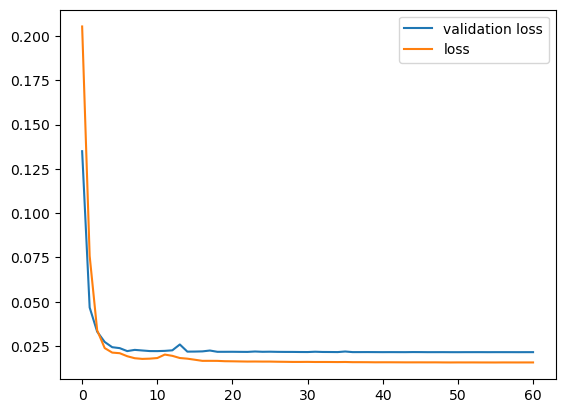

In [126]:
plt.plot(history['val_loss'], label='validation loss')
plt.plot(history['loss'], label='loss')
plt.legend(loc='upper right')
plt.show()

In [127]:
predictions = model.predict(X_test)
print(predictions.shape)

rmse = tfk.metrics.RootMeanSquaredError()
rmse.update_state(y_test, predictions)
rmse.result()

(168, 50, 7)


<tf.Tensor: shape=(), dtype=float32, numpy=0.14399135>

In [128]:
model.save('model/biLSTMGAP')

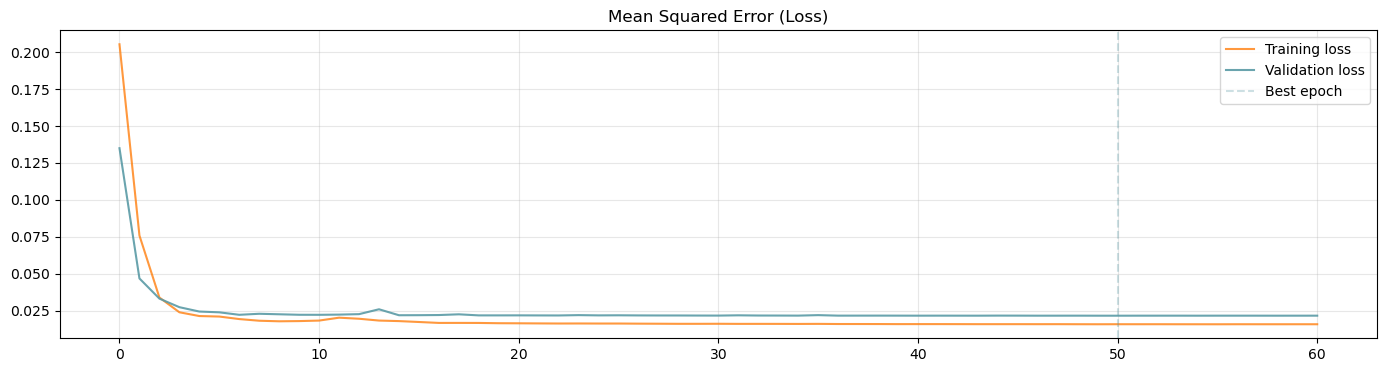

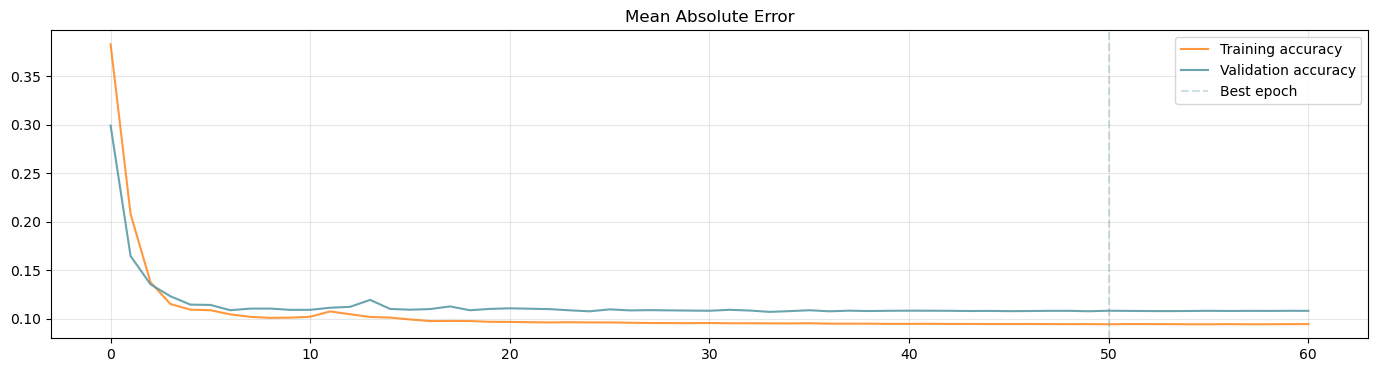

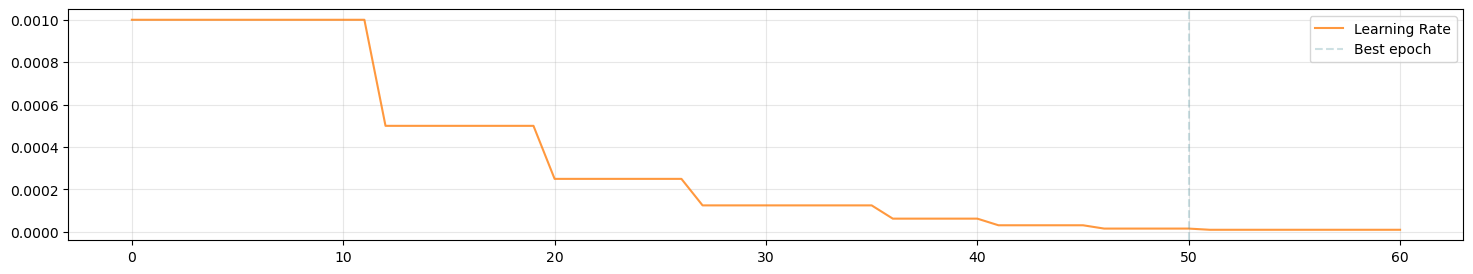

In [129]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()